In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from google.colab import files

In [3]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 60.6MB 1.4MB/s 


In [4]:
!pip install lightgbm --install-option=--gpu
from lightgbm.sklearn import LGBMRegressor

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
def get_loss(pred, actual):
  loss = mean_squared_error(pred, actual)
  result = np.sqrt(loss)
  return result

In [0]:
def kfold_validate(X, y, te, model, col):
    scores = np.zeros(k)
    for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
        X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
        X_val, y_val = X.iloc[val_idx, :], y[val_idx]

        model.fit(X_tr, y_tr)
        pred_val = model.predict(X_val)
        scores[i] = get_loss(pred_val, y_val)
        print("========={}-th Fold Score: {}".format(i, scores[i]))
        
        meta_tr[col][val_idx] = pred_val
        meta_tr['val'][val_idx] = y_val

    print("=========Total Score: ", np.mean(scores))
    model.fit(X, y)
    meta_te[col] = model.predict(te)

## Load the data

In [113]:
# Import the all dataset
tr = pd.read_csv('train_3.csv')
te = pd.read_csv('test_3.csv')

#tr = pd.read_csv('train_3_2.csv')
#te = pd.read_csv('test_3_2.csv')

#r = pd.read_csv('train_3_svd.csv')
#e = pd.read_csv('test_3_svd.csv')

# Final check
print("The size of the train set ", tr.shape)    # (3000, 377)
print("The size of the test set ", te.shape)

The size of the train set  (3000, 377)
The size of the test set  (4398, 376)


In [114]:
print("=======NAs in train set\n", tr.isnull().sum()[tr.isnull().sum() != 0])
print("=======NAs in test set\n", te.isnull().sum()[te.isnull().sum() != 0])

=======NAs in train set
 n_crew_profile    16
dtype: int64
=======NAs in test set
 n_crew_profile         22
r_rating_totalVotes     1
dtype: int64


In [0]:
tr.fillna(-1, inplace = True)
te.fillna(-1, inplace = True)

In [116]:
te.iloc[:, :45].describe()

,budget_log,popularity_log,runtime_h,runtime_log,runtime_m,status,is_collection,is_homepage,n_genres,n_prod_count,n_prod_comp,n_spoken_lang,cast_male,crew_male,n_crew_profile,year,month,day,weekofday,rating,n_cast_log,n_crew_log,popularity2_log,totalVotes_log,popularity_diff_log,r_runtime_rating,r_rating_totalVotes,r_budget_rating,r_popularity_totalVotes,r_popularity_rating,r_popularity_ngenres,r_popularity_n_cast,r_budget_totalVotes,r_budget_runtime,r_budget_year,r_totalVotes_year,r_rating_year,r_rating_year2,m_rating_totalVotes,m_year_popularity,m_year_budget,m_year_totalVotes_log,m_year_rating,m_year_runtime,m_year_n_crew_log
count,4398.000000,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4.398000e+03,4398.000000,4398.000000,4.398000e+03,4.398000e+03,4.398000e+03,4.398000e+03,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4.398000e+03,4398.000000,4398.000000,4398.000000,4398.000000
mean,11.799167,1.985449e+00,1.225330,4.659979,0.015688,1.000227,0.199409,0.322874,2.497726,1.364484,2.922237,1.451342,0.233584,0.088549,0.290208,1999.675534,6.889723,15.379036,3.228286,6.114461,2.864404,2.743025,2.012873,5.412860,0.292240,-0.015062,0.096662,4.187490e+06,3.427411,0.524288,3.934207e+00,5.190416e-01,1.069355e+05,2.040717e+05,2.725831e+05,0.073227,0.003058,0.086140,5.410260,1.981314,2.257493e+07,5.409854,6.114776,0.000765,20.975950
std,7.444733,7.509477e-01,0.452848,0.309302,0.998423,0.058407,0.399601,0.467628,1.111836,0.792381,2.250990,0.888750,0.149346,0.119434,0.254200,15.286707,3.370176,8.571856,1.341997,1.544581,0.688653,0.995944,0.611603,1.946927,0.248682,1.811774,0.350092,2.896592e+07,1.378183,1.461456,4.480953e+00,1.490366e+00,1.455504e+06,3.287007e+05,4.622628e+05,0.057485,0.000776,0.092460,1.135203,0.176196,9.773718e+06,0.479200,0.295658,0.127683,3.764882
min,0.000000,9.999995e-07,-0.000000,0.000000,-2.177292,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,1922.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.470004,0.000000,0.000287,-21.772921,-1.000000,0.000000e+00,-2.072503,0.000010,5.000000e-07,1.666667e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.690821,0.191453,3.000000e+02,1.791759,5.500000,-1.854838,8.000000
25%,0.000000,1.588252e+00,1.000000,4.553877,-0.548900,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.125000,0.000000,0.120000,1992.000000,4.000000,8.000000,2.000000,5.700000,2.484907,2.197225,1.676208,4.158883,0.109869,-0.091133,0.005544,0.000000e+00,2.556456,0.263012,1.647093e+00,2.015742e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.052699,0.002850,0.066667,5.381652,1.911811,1.324143e+07,5.112093,5.942373,-0.048236,19.090909
50%,15.816991,2.137975e+00,1.000000,4.653960,0.144376,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.214286,0.058824,0.240000,2004.000000,7.000000,15.000000,4.000000,6.400000,2.833213,2.708050,2.117700,5.549076,0.238206,0.024892,0.019939,1.142857e+06,3.392426,0.333746,3.007754e+00,3.679115e-01,1.748362e+04,6.796117e+04,1.011236e+05,0.069521,0.003182,0.076220,5.602962,1.953762,2.664833e+07,5.489345,6.060645,0.001543,20.035370
75%,17.147715,2.479770e+00,1.000000,4.779123,0.724793,1.000000,0.000000,1.000000,3.000000,1.000000,4.000000,2.000000,0.333333,0.130435,0.400000,2011.000000,10.000000,23.000000,4.000000,7.000000,3.218876,3.367296,2.408745,6.806829,0.410693,0.125487,0.075291,4.516129e+06,4.445976,0.396209,4.959823e+00,6.015091e-01,6.118554e+04,2.576554e+05,3.460351e+05,0.085683,0.003497,0.089157,5.827735,2.021852,2.898095e+07,5.710692,6.215789,0.060135,21.323274
max,19.376192,6.307166e+00,5.000000,5.771441,1.627665,3.000000,1.000000,1.000000,8.000000,12.000000,26.000000,9.000000,1.00

In [0]:
X = tr.drop('revenue_log', axis = 1)

In [0]:
# Create meta-trainset
nrow = X.shape[0]
ncol = 8
dims = np.zeros((nrow, ncol))

meta_tr = pd.DataFrame(dims, columns = ['el', 'rf', 'knn', 'svm', 'xg', 'cb', 'lg', 'ke'])
meta_tr['val'] = 0

In [0]:
# Create meta-testset
nrow = te.shape[0]
dims = np.zeros((nrow, ncol))
meta_te = pd.DataFrame(dims, columns = ['el', 'rf', 'knn', 'svm', 'xg', 'cb', 'lg', 'ke'])

In [0]:
# Cross Validation
k = 10
seed = 10
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

## 1st Layer Modeling

In [0]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = seed)

In [0]:
def split_validate(model):
  model.fit(X_tr, y_tr)
  pred = model.predict(X_val)
  print(get_loss(pred, y_val))

### Elastic-Net

In [49]:
model_el = ElasticNet(alpha = .01, l1_ratio = 0, max_iter = 5000)
#split_validate(model_el)
kfold_validate(X, y, te, model_el, 'el')

2.140556030893825


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4936.058098164045, tolerance: 2.229425564962863
  positive)


### KNN 

In [66]:
model_knn = KNeighborsRegressor(n_neighbors = 100, weights = 'distance', p = 2)  
kfold_validate(X, y, te, model_knn, 'knn')

=========0-th Fold Score: 2.4326816812388268
=========1-th Fold Score: 2.470010040868674
=========2-th Fold Score: 2.699330563587398
=========3-th Fold Score: 2.6293797045142626
=========4-th Fold Score: 2.3782903431882025
=========5-th Fold Score: 2.164330014010957
=========6-th Fold Score: 2.186946685574117
=========7-th Fold Score: 3.02473808531261
=========8-th Fold Score: 2.2255573680885967
=========9-th Fold Score: 2.5561937299728554
=========Total Score:  2.47674582163565


### Random Forest

In [0]:
model_rf = RandomForestRegressor(n_estimators = 3000,
                                 criterion = 'mse',
                                 #min_samples_split = .7,
                                 #min_samples_leaf = 100,
                                 max_depth = 9)
kfold_validate(X, y, te, model_rf, 'rf')

In [62]:
model_rf = RandomForestRegressor(n_estimators = 3000,
                                 criterion = 'mse',
                                 max_depth = 11)
meta_tr['rf_2'] = 0
meta_te['rf_2'] = 0
kfold_validate(X, y, te, model_rf, 'rf_2')

2.038890869183459


### Kernel SVM

In [0]:
# scaling?

In [63]:
model_svm = SVR(kernel = 'rbf')  
#split_validate(model_svm)
kfold_validate(X, y, te, model_svm, 'svm')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2.9226708024582577


### Xgboost

In [0]:
model_xg = xgb.XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000, 
                            max_depth = 11, 
                            learning_rate = 0.01,
                            early_stopping_rounds = 500,
                            gamma = 1.0, 
                            #alpha = .6,
                            subsample = 0.7,   
                            colsample_bytree = 0.6, 
                            colsample_bylevel = 0.5,
                            silent = True)
kfold_validate(X, y, te, model_xg, 'xg')

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========0-th Fold Score: 1.8926797164427573


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========1-th Fold Score: 1.930241560475767


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========2-th Fold Score: 1.9955216672204383


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========3-th Fold Score: 1.7101009999362011


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========4-th Fold Score: 2.000500309488473


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========5-th Fold Score: 1.7046000800399044


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========6-th Fold Score: 1.6826374813475944


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========7-th Fold Score: 2.338184839300091


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========8-th Fold Score: 1.7997787103353724


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========9-th Fold Score: 1.8774223140382065
=========Total Score:  1.8931667678624806


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Catboost

In [0]:
model_cb = CatBoostRegressor(bagging_temperature = 0.3,  
                             colsample_bylevel = 0.7,  
                             depth = 9,   
                             early_stopping_rounds = 500,   
                             eval_metric = 'RMSE',
                             iterations = 3000,                             
                             learning_rate = .01,    
                             logging_level = 'Silent')

kfold_validate(X, y, te, model_cb, 'cb')

=========0-th Fold Score: 1.9128576237404389
=========1-th Fold Score: 1.9447735513363107
=========2-th Fold Score: 1.8985864060497646
=========3-th Fold Score: 1.6045882942972496
=========4-th Fold Score: 1.930594480043148
=========5-th Fold Score: 1.7200524718803278
=========6-th Fold Score: 1.591614018376639
=========7-th Fold Score: 2.2593741799117164
=========8-th Fold Score: 1.793942305366387
=========9-th Fold Score: 1.9188637604623882
=========Total Score:  1.8575247091464369


In [0]:
model_cb = CatBoostRegressor(bagging_temperature = 0.3,  
                             colsample_bylevel = 0.7,  
                             depth = 9,   
                             early_stopping_rounds = 500,   
                             eval_metric = 'RMSE',
                             iterations = 3000,
                             learning_rate = .05,
                             logging_level = 'Silent')

meta_tr['cb_2'] = 0
meta_te['cb_2'] = 0
kfold_validate(X, y, te, model_cb, 'cb_2')

=========0-th Fold Score: 1.9163807306574596


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


=========1-th Fold Score: 1.929960929974648
=========2-th Fold Score: 1.90850615412896
=========3-th Fold Score: 1.569344715801719
=========4-th Fold Score: 1.9585831036319743
=========5-th Fold Score: 1.7853218865613658
=========6-th Fold Score: 1.6004778629738625
=========7-th Fold Score: 2.2317453007273813
=========8-th Fold Score: 1.7692432336211554
=========9-th Fold Score: 1.8245785552881186
=========Total Score:  1.8494142473366644


### Lightgbm

In [0]:
import lightgbm as lgb
params = {'objective' : 'regression',
          'num_iterations' : 5000, 
          'max_depth' : 13, 
          'num_leaves' : 100, 
          'learning_rate': 0.05, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100, 
          'colsample_bytree': 0.7, 
          'subsample_freq': 1,  
          'lambda_l1' : 0.01, 
          'lambda_l2' : 0.7, 
          'subsample' : 0.6, 
          'verbose' : -1}

In [0]:
scores = np.zeros(10)
for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    
    tr_data = lgb.Dataset(X_tr, label = y_tr)
    val_data = lgb.Dataset(X_val, label = y_val)

    hist = {}
    model_lg = lgb.train(params, tr_data, 
                         valid_sets = [val_data],
                         verbose_eval = -1, 
                         early_stopping_rounds = 500,
                         callbacks = [lgb.record_evaluation(hist)])
    
    pred_val = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
        
    meta_tr['lg'][val_idx] = pred_val
    meta_tr['val'][val_idx] = y_val

print("=========Total Score: ", np.mean(scores))
meta_te['lg'] = model_lg.predict(te)

In [0]:
params = {'objective' : 'regression',
          'num_iterations' : 5000, 
          'max_depth' : 9, 
          'num_leaves' : 100, 
          'learning_rate': 0.005, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100, 
          'colsample_bytree': 0.5, 
          'subsample_freq': 1,  
          'lambda_l1' : 0.01, 
          'lambda_l2' : 0.7, 
          'subsample' : 0.8, 
          'verbose' : -1}

In [0]:
meta_tr['lg_2'] = 0
meta_te['lg_2'] = 0

scores = np.zeros(10)
for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    
    tr_data = lgb.Dataset(X_tr, label = y_tr)
    val_data = lgb.Dataset(X_val, label = y_val)

    hist = {}
    model_lg = lgb.train(params, tr_data, 
                         valid_sets = [val_data],
                         verbose_eval = -1, 
                         early_stopping_rounds = 500,
                         callbacks = [lgb.record_evaluation(hist)])
    
    pred_val = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
        
    meta_tr['lg_2'][val_idx] = pred_val

print("=========Total Score: ", np.mean(scores))
meta_te['lg_2'] = model_lg.predict(te)

### Keras

In [96]:
print(X.shape[1])
print(X.shape[1] /2)

376
188.0


In [176]:
# initialize the model
model = Sequential()

# create hidden layers
model.add(Dense(input_dim = X.shape[1], output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 64, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 32, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 16, activation = 'relu'))
model.add(Dense(output_dim = 1))

# compile: stochastic gradient descent
model.compile(optimizer = Adam(lr=0.01),  
              loss = 'mse',
              metrics = ['mean_squared_error'])

# early stopper
early_stopper = EarlyStopping(patience = 5)

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=376, activation="relu", units=128)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 128)               48256     
_________________________________________________________________
dense_97 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_42 (Batc (None, 64)                256       
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_43 (Batc (None, 32)                128       
_________________________________________________________________
dense_99 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 17        
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if sys.path[0] == '':


In [0]:
model_ke = model

results = np.zeros((3000, 1))
scores = np.zeros(10)

for i, (tr_idx, val_idx) in enumerate(cv.split(X)):
    X_tr, y_tr = X.iloc[tr_idx, :], y[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]

    model_ke.fit(X_tr, y_tr, 
                validation_data = (X_val, y_val),
                batch_size = 300,
                nb_epoch = 100,
                callbacks = [early_stopper],
                verbose= -1)
    pred_val = model_ke.predict(X_val)
    scores[i] = get_loss(pred_val, y_val)
    print("========={}-th Fold Score: {}".format(i, scores[i]))
    results[val_idx] = pred_val
    
meta_tr['ke'] = results
print("=========Total Score: ", np.mean(scores))

model_ke.fit(X, y,
            batch_size = 100,
            nb_epoch = 100)
meta_te['ke'] = model_ke.predict(te)

### Evaluation

In [187]:
meta_tr[meta_tr.val < 10].sample(20)

,el,rf,knn,xg,cb,lg,val,rf_2,cb_2,lg_2,ke
2759,11.726053,12.260388,17.812053,13.448273,12.311934,13.522282,2.639057,12.269425,13.124819,13.605975,14.015950
2399,13.009495,11.494655,9.417023,11.484671,12.421524,11.864791,2.772589,11.354885,11.490400,10.964918,12.011803
403,13.331793,11.509266,12.046866,10.708562,11.837729,10.095852,7.293018,11.316783,10.795259,10.317290,12.389497
2384,10.748633,11.811158,17.565365,11.493032,11.824664,10.973538,6.510258,11.800136,11.428011,11.680458,12.421073
269,10.725126,11.663861,12.999401,10.838148,11.799719,12.041525,3.044522,11.547676,11.544646,11.632935,12.429787
2936,11.365041,12.263872,14.362231,11.767242,12.385394,10.217170,9.147720,12.114514,12.756856,10.673190,13.473037
1076,13.763606,13.521673,13.261136,13.303164,12.901129,12.271754,9.615872,13.544769,12.491733,12.302344,12.134344
313,13.453681,12.667128,9.040907,12.490219,12.278696,12.579367,8.747987,12.419113,13.134163,13.148343,12.754200
151,12.704819,12.322156,11.239426,11.947454,12.018314,12.054646,9.735424,12.089180,11.998466,12.230217,12.089387
1141,11.675217,12.549386,15.403439,11.721784,12.167464,12.472440,2.484907,12.422522,12.210152,12.061439,11.688381


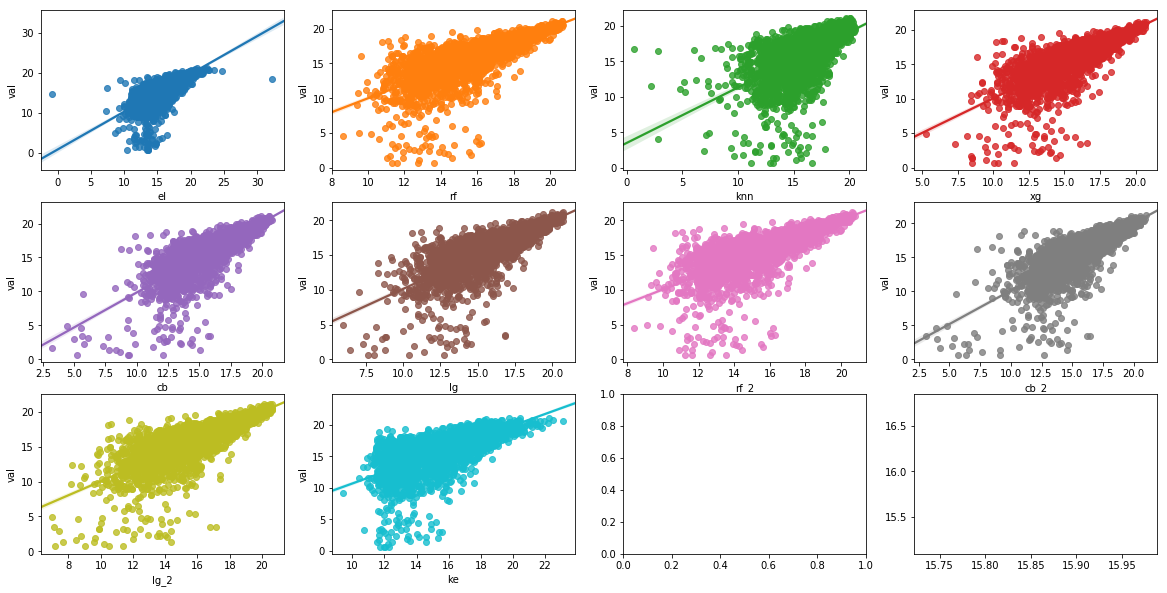

In [188]:
fig, axes = plt.subplots(3, 4, figsize = (20, 10))

for i, col in enumerate(meta_tr.columns[meta_tr.columns != 'val']):
  sns.regplot(x = col, y = 'val', data = meta_tr, ax = axes[i//4, i % 4])

In [0]:
meta_tr.to_csv('meta_tr.csv', index = False)
meta_te.to_csv('meta_te.csv', index = False)

## 2nd Layer Modeling

In [0]:
meta_tr = pd.read_csv('meta_tr.csv')
meta_te = pd.read_csv('meta_te.csv')

In [309]:
print("The size of the train set ", meta_tr.shape)
print("The size of the test set ", meta_te.shape)

The size of the train set  (3000, 11)
The size of the test set  (4398, 10)


In [0]:
y = meta_tr.val
X_tr = meta_tr.drop('val', axis = 1)

te = meta_te

In [0]:
# Create meta-train set
cols = ['lr', 'el', 'rd', 'knn', 'rf', 'rf2', 'ad']

nrow = X.shape[0]
ncol = len(cols)
dims = np.zeros((nrow, ncol))

meta_tr = pd.DataFrame(dims, columns = cols)
meta_tr['val'] = 0

# Create meta-test set
nrow = te.shape[0]
dims = np.zeros((nrow, ncol))
meta_te = pd.DataFrame(dims, columns = cols)

# Cross Validation
k = 5
seed = 30
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

### Linear Regression

In [312]:
model_lr = LinearRegression(normalize=True)
kfold_validate(X_tr, y, te, model_lr, 'lr')     # 1.8395

=========0-th Fold Score: 1.9634880947149107
=========1-th Fold Score: 1.917546194906108
=========2-th Fold Score: 1.7325427084145366
=========3-th Fold Score: 1.8829488863143353
=========4-th Fold Score: 1.7011953797640753
=========Total Score:  1.8395442528227932


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### Elastic Net

In [313]:
model_el = ElasticNet(alpha = .005, l1_ratio = 0, max_iter = 5000)
kfold_validate(X_tr, y, te, model_el, 'el')   # 1.8383

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3863.9462458838234, tolerance: 2.1667939388572846
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3915.002573620401, tolerance: 2.158456468524547
  positive)


=========0-th Fold Score: 1.9639524650709916
=========1-th Fold Score: 1.918609389376437


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4123.063434188057, tolerance: 2.2502944354982315
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3961.6990069369544, tolerance: 2.1888173550024463
  positive)


=========2-th Fold Score: 1.7305386536311462
=========3-th Fold Score: 1.8829916295897953
=========4-th Fold Score: 1.6991249601404472
=========Total Score:  1.8390434195617633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4154.637776755654, tolerance: 2.2907138480499496
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5013.478491063445, tolerance: 2.7638801457781614
  positive)


### Ridge Regression

In [314]:
model_rd = Ridge(alpha = .001, normalize = True)
kfold_validate(X_tr, y, te, model_rd, 'rd')   # 1.8383

=========0-th Fold Score: 1.9639294262931537
=========1-th Fold Score: 1.9186387490478984
=========2-th Fold Score: 1.7304466709778725
=========3-th Fold Score: 1.8829974641379836
=========4-th Fold Score: 1.698984895728641
=========Total Score:  1.8389994412371098


### KNN

In [315]:
model_knn = KNeighborsRegressor(n_neighbors = 50, weights = 'distance', p = 2)
kfold_validate(X_tr, y, te, model_knn, 'knn')    # 1.8870

=========0-th Fold Score: 2.0391670361866496
=========1-th Fold Score: 2.005897014526754
=========2-th Fold Score: 1.761701579935979
=========3-th Fold Score: 1.9579847772558894
=========4-th Fold Score: 1.680541547006536
=========Total Score:  1.8890583909823615


### Random Forest

In [316]:
model_rf = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
kfold_validate(X_tr, y, te, model_rf, 'rf')   # 1.85

=========0-th Fold Score: 1.9944366819962198
=========1-th Fold Score: 1.9157898643668945
=========2-th Fold Score: 1.777300515323388
=========3-th Fold Score: 1.8869214395524703
=========4-th Fold Score: 1.679063655065071
=========Total Score:  1.850702431260809


In [317]:
model_rf = RandomForestRegressor(n_estimators = 1000, max_depth = 5)
kfold_validate(X_tr, y, te, model_rf, 'rf2')    # 1.84

=========0-th Fold Score: 1.968362268628032
=========1-th Fold Score: 1.929807511920929
=========2-th Fold Score: 1.7760327538279166
=========3-th Fold Score: 1.8862640438199574
=========4-th Fold Score: 1.6830348752315458
=========Total Score:  1.848700290685676


### Adaboost

In [318]:
from sklearn.ensemble import AdaBoostRegressor

model_ad = AdaBoostRegressor(n_estimators = 1000, learning_rate = .05,  
                             loss = 'square', random_state = seed)
kfold_validate(X_tr, y, te, model_rf, 'ad')    # 1.84

=========0-th Fold Score: 1.9663249495616044
=========1-th Fold Score: 1.9252008332356974
=========2-th Fold Score: 1.7740964886438637
=========3-th Fold Score: 1.8885498333502078
=========4-th Fold Score: 1.6867436313130222
=========Total Score:  1.848183147220879


In [319]:
meta_tr['xg'] = 0
meta_te['xg'] = 0

model_xg = XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000,
                            max_depth = 9,
                            learning_rate = 0.05,
                            early_stopping_rounds = 100,
                            gamma = 1.0,
                            subsample = 0.5,
                            colsample_bytree = 0.7,
                            colsample_bylevel = 0.7,
                            silent = True)
kfold_validate(X_tr, y, te, model_xg, 'xg')    # 1.8289

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========0-th Fold Score: 2.0275699213045404


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========1-th Fold Score: 2.103934284089309


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========2-th Fold Score: 1.8580909171205104


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========3-th Fold Score: 1.9803042285127714


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


=========4-th Fold Score: 1.8291150106740293
=========Total Score:  1.9598028723402319


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Evaluation

In [324]:
meta_tr.sample(10)

,lr,el,rd,rf2,ad,val
1252,15.644901,15.633591,15.633217,15.874064,15.878484,16.670942
815,17.892752,17.897398,17.897480,17.803690,17.820368,17.922127
556,12.234287,12.301436,12.303668,13.458657,13.441910,15.400296
2827,13.633848,13.718749,13.718573,13.643831,13.667294,16.140260
1952,12.388103,12.361268,12.361021,11.834604,11.811552,9.604879
2794,17.580487,17.576457,17.575660,17.679752,17.684688,17.588930
949,15.878907,15.858613,15.859415,15.785184,15.780782,15.952686
2655,13.335288,13.328622,13.327949,13.567408,13.580275,12.844415
2545,18.285974,18.286174,18.286413,18.302773,18.303947,17.738437
1980,15.650273,15.640175,15.640162,15.784092,15.788236,15.301103


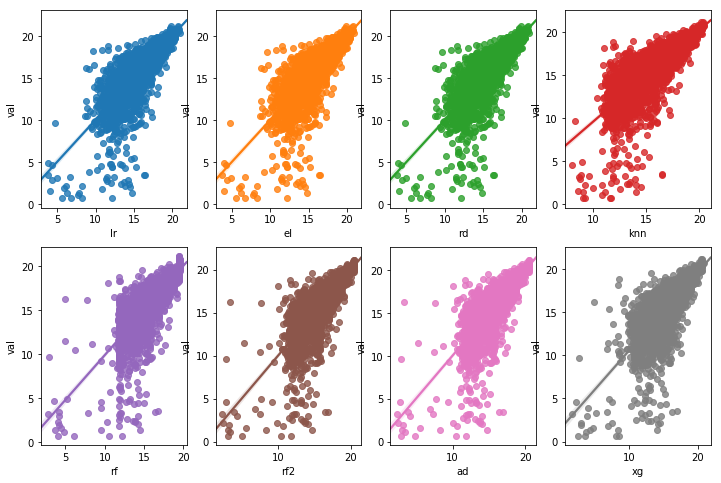

In [321]:
fig, axes = plt.subplots(2, 4, figsize = (12, 8))

for i, col in enumerate(meta_tr.columns[meta_tr.columns != 'val']):
  sns.regplot(x = col, y = 'val', data = meta_tr, ax = axes[i//4, i%4])

In [0]:
#final = (meta_te.lr + meta_te.el + meta_te.rf)/3

#final = (meta_te.lr + meta_te.el + meta_te.rd +  meta_te.rf2 + meta_te.ad)/5

# Current Best score
#final = (meta_te.lr + meta_te.el + meta_te.rd + meta_te.knn + meta_te.rf + meta_te.rf2 + meta_te.ad)/7
final = (meta_te.lr + meta_te.el + meta_te.rd + meta_te.rf + meta_te.rf2 + meta_te.ad)/6

In [0]:
meta_tr.drop(['knn', 'rf', 'xg'], axis = 1, inplace = True)
meta_te.drop(['knn', 'rf', 'xg'], axis = 1, inplace = True)

## 3rd Layer Modeling

In [0]:
y = meta_tr.val
X_tr = meta_tr.drop('val', axis = 1)

te = meta_te

In [0]:
# Create meta-train set
cols = ['lr', 'rd', 'rf', 'rf2']

nrow = X.shape[0]
ncol = len(cols)
dims = np.zeros((nrow, ncol))

meta_tr = pd.DataFrame(dims, columns = cols)
meta_tr['val'] = 0

# Create meta-test set
nrow = te.shape[0]
dims = np.zeros((nrow, ncol))
meta_te = pd.DataFrame(dims, columns = cols)

# Cross Validation
k = 5
seed = 10
cv = KFold(n_splits = k, shuffle = True, random_state = seed)

In [332]:
model_lr = LinearRegression()
kfold_validate(X_tr, y, te, model_lr, 'lr')    # 1.8417

=========0-th Fold Score: 1.8749219858756498


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


=========1-th Fold Score: 1.7264935076210974
=========2-th Fold Score: 1.8345704477634586
=========3-th Fold Score: 1.954080546930758
=========4-th Fold Score: 1.8099007042821675
=========Total Score:  1.8399934384946264


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [333]:
model_rd = Ridge(alpha = .01, normalize = True)
kfold_validate(X_tr, y, te, model_rd, 'rd')     # 1.8332

=========0-th Fold Score: 1.865633083073311
=========1-th Fold Score: 1.7151360871446715
=========2-th Fold Score: 1.8322725155930453
=========3-th Fold Score: 1.9509797812790473
=========4-th Fold Score: 1.8076914095074723
=========Total Score:  1.8343425753195093


In [334]:
model_rf = RandomForestRegressor(n_estimators = 3000, max_depth = 3)
kfold_validate(X_tr, y, te, model_rf, 'rf')     # 1.8279

=========0-th Fold Score: 1.864325941174517
=========1-th Fold Score: 1.7652931136590646
=========2-th Fold Score: 1.7900116320411033
=========3-th Fold Score: 1.9829253104587667
=========4-th Fold Score: 1.7558130279078095
=========Total Score:  1.8316738050482524


In [0]:
model_rf = RandomForestRegressor(n_estimators = 2000, max_depth = 5)
kfold_validate(X_tr, y, te, model_rf, 'rf2')    # 1.8289

=========0-th Fold Score: 1.8553337124217975
=========1-th Fold Score: 1.7989675153195728
=========2-th Fold Score: 1.7921104728898203


In [0]:
meta_tr.sample(10)

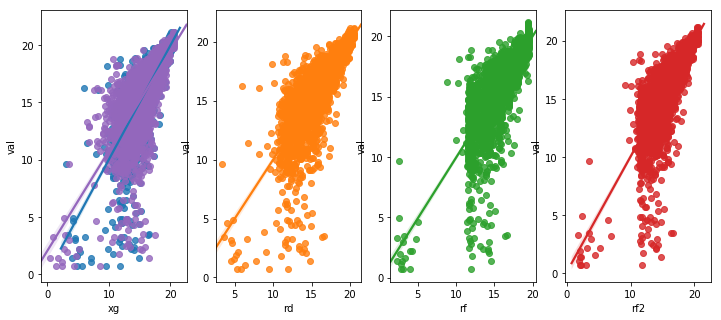

In [283]:
fig, axes = plt.subplots(1, 5, figsize = (12, 5))

for i, col in enumerate(meta_tr.columns[meta_tr.columns != 'val']):
  sns.regplot(x = col, y = 'val', data = meta_tr, ax = axes[i%5])

In [0]:
# Averaging the final result
#final = (meta_te.lr + meta_te.rd + meta_te.rf2)/3
#final = (meta_te.rf + meta_te.rf2)/2

final = (meta_te.rf2 + meta_te.rd + meta_te.lr)/3

## Submission

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = np.expm1(final)

sub.to_csv('mysub.csv', index = False)
#files.download('mysub.csv')

In [224]:
sub.shape

(4398, 2)

In [0]:
from getpass import getpass
import os 

user = 'jjone36'
key = 'cf8dcde20a60798fe4fb91b2ba5158e8'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [329]:
!kaggle competitions submit -c tmdb-box-office-prediction -f mysub.csv -m "keras add + 2nd lr 6 models"

100% 100k/100k [00:12<00:00, 8.41kB/s]
Successfully submitted to TMDB Box Office Prediction